# Étape 2 – Baseline frame-wise (Colab Web)

Ce notebook sert à **piloter l'entraînement de la baseline frame-wise** sur Google Colab / Colab Pro+.

La logique d'entraînement (DataLoaders, modèle, pertes, optimiseur, scheduler, mAP, etc.)
est implémentée dans `src/` dans le dépôt du projet.

Ce notebook se contente de :
1. Monter Google Drive (`MyDrive/QV-Pipe/`).
2. Cloner ou mettre à jour le dépôt dans `/content`.
3. Installer les dépendances Python.
4. Définir les chemins vers les données (frames, splits, labels).
5. Lancer le script d'entraînement `src/train/framewise_baseline.py` sur un GPU (A100 si possible).

> Avant de lancer : menu **Runtime → Change runtime type → GPU**.


# **1. Configuration**

In [1]:
# Vérifier le GPU Colab disponible
!nvidia-smi

Thu Nov 27 18:29:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pathlib import Path

# --- Repo GitHub du projet ---
REPO_URL = "https://github.com/Simon-VDC/qv-pipe-classifier.git"  # 🔁 À adapter
PROJECT_NAME = "qv-pipe-classifier"                              # nom du dossier du projet

# --- Chemins Colab ---
COLAB_ROOT = Path("/content")
PROJECT_ROOT = COLAB_ROOT / PROJECT_NAME

# --- Chemins Drive ---
DRIVE_ROOT = Path("/content/drive/MyDrive/QV Pipe")
DATA_DIR = DRIVE_ROOT / "data"

FRAMES_DIR = DATA_DIR / "frames" / "5_forstep1and2"
SPLITS_DIR = DATA_DIR / "splits"
LABELS_PATH = DATA_DIR / "labels" / "track1-qv_pipe_train.json"

MODELS_DIR = DRIVE_ROOT / "models" / "baseline_framewise"

print("PROJECT_ROOT :", PROJECT_ROOT)
print("DRIVE_ROOT   :", DRIVE_ROOT)
print("FRAMES_DIR   :", FRAMES_DIR)
print("SPLITS_DIR   :", SPLITS_DIR)
print("LABELS_PATH  :", LABELS_PATH)
print("MODELS_DIR   :", MODELS_DIR)


PROJECT_ROOT : /content/qv-pipe-classifier
DRIVE_ROOT   : /content/drive/MyDrive/QV Pipe
FRAMES_DIR   : /content/drive/MyDrive/QV Pipe/data/frames/5_forstep1and2
SPLITS_DIR   : /content/drive/MyDrive/QV Pipe/data/splits
LABELS_PATH  : /content/drive/MyDrive/QV Pipe/data/labels/track1-qv_pipe_train.json
MODELS_DIR   : /content/drive/MyDrive/QV Pipe/models/baseline_framewise


In [4]:
import os

if not PROJECT_ROOT.exists():
    # Clone la première fois
    !git clone {REPO_URL} {PROJECT_ROOT}
else:
    # Mise à jour si déjà présent
    %cd {PROJECT_ROOT}
    !git pull

%cd {PROJECT_ROOT}
!ls


Cloning into '/content/qv-pipe-classifier'...
remote: Enumerating objects: 293, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 293 (delta 39), reused 78 (delta 12), pack-reused 168 (from 1)
Receiving objects: 100% (293/293), 355.72 KiB | 4.81 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/content/qv-pipe-classifier
CONFIG.md      docs		exp	   project_tree.txt  requirements
data	       ENVIRONMENT.md	LICENSE    README.md	     scripts
DATA_NOTES.md  environment.yml	notebooks  reports	     src


In [5]:
%cd {PROJECT_ROOT}

# Installer les dépendances Step 2
!pip install -r requirements/step2_training.txt


/content/qv-pipe-classifier
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 18.6 MB/s eta 0:00:00


In [6]:
print("Frames :", FRAMES_DIR.exists())
print("Splits :", SPLITS_DIR.exists())
print("Labels :", LABELS_PATH.exists())

print("\nContenu du dossier splits :")
!ls {SPLITS_DIR}

print("\nQuelques frames :")
!ls {FRAMES_DIR} | head -n 10


Frames : True
Splits : True
Labels : True

Contenu du dossier splits :
ls: cannot access '/content/drive/MyDrive/QV': No such file or directory
ls: cannot access 'Pipe/data/splits': No such file or directory

Quelques frames :
ls: cannot access '/content/drive/MyDrive/QV': No such file or directory
ls: cannot access 'Pipe/data/frames/5_forstep1and2': No such file or directory


In [7]:
import sys
sys.path.append(str(PROJECT_ROOT))

try:
    import src
    print("Import de src OK ✅")
except Exception as e:
    print("Erreur d'import de src ❌")
    print(e)


Import de src OK ✅


### 🔧 Configuration de l'entraînement (variables)

Ces variables contrôlent le comportement de l'entraînement pour l'étape 2.

- **FOLD** : numéro du fold utilisé pour la validation (0 à 4).  
  Le modèle s'entraîne sur les 4 autres folds.  
  Ex. `FOLD = 0` → validation sur le fold 0, entraînement sur 1–4.

- **EPOCHS** : nombre d'itérations complètes sur les données d'entraînement.  
  Typique pour une baseline : 10 à 20 epochs.

- **BATCH_SIZE** : nombre de vidéos par batch.  
  Chaque vidéo contient 5 frames.  
  Ex. `BATCH_SIZE = 32` → 32 vidéos × 5 frames par traitement.

- **LR (Learning Rate)** : taux d’apprentissage maximal utilisé par OneCycleLR.  
  Valeur standard : 1e-3.

Ces paramètres seront ensuite passés au script d'entraînement `src/train/framewise_baseline.py`.


In [8]:
%cd {PROJECT_ROOT}
!pwd
!ls


/content/qv-pipe-classifier
/content/qv-pipe-classifier
CONFIG.md      docs		exp	   project_tree.txt  requirements
data	       ENVIRONMENT.md	LICENSE    README.md	     scripts
DATA_NOTES.md  environment.yml	notebooks  reports	     src


In [9]:
from pathlib import Path

DRIVE_ROOT = Path("/content/drive/MyDrive/QV Pipe")
DATA_DIR = DRIVE_ROOT / "data"

FRAMES_DIR = DATA_DIR / "frames" / "5_forstep1and2"
SPLITS_DIR = DATA_DIR / "splits"
LABELS_PATH = DATA_DIR / "labels" / "track1-qv_pipe_train.json"
MODELS_DIR = DRIVE_ROOT / "models" / "baseline_framewise"

print("FRAMES_DIR existe :", FRAMES_DIR.exists())
print("SPLITS_DIR existe :", SPLITS_DIR.exists())
print("LABELS_PATH existe :", LABELS_PATH.exists())

print("\nContenu de SPLITS_DIR :")
!ls "{SPLITS_DIR}"

print("\nQuelques frames :")
!ls "{FRAMES_DIR}" | head -n 10


FRAMES_DIR existe : True
SPLITS_DIR existe : True
LABELS_PATH existe : True

Contenu de SPLITS_DIR :
frames_5_forstep1and2_folds.csv  video_folds_5fold.csv

Quelques frames :
1000_f00.jpg
1000_f01.jpg
1000_f02.jpg
1000_f03.jpg
1000_f04.jpg
1001_f00.jpg
1001_f04.jpg
1002_f00.jpg
1002_f01.jpg
1002_f02.jpg


# **2. Dry-run**
 léger pour tester que tous est cablé OK = Dry run OK. Exiting.

In [11]:
%cd {PROJECT_ROOT}

CMD = f"""
python -m src.train.framewise_baseline \
    --frames_dir "{DRIVE_ROOT}" \
    --splits_csv "{SPLITS_DIR / 'frames_5_forstep1and2_folds.csv'}" \
    --labels_json "{LABELS_PATH}" \
    --models_dir "{MODELS_DIR}" \
    --fold {FOLD} \
    --epochs {EPOCHS} \
    --batch_size {BATCH_SIZE} \
    --lr {LR} \
    --dry_run
"""

print("Commande exécutée :")
print(CMD)

!{CMD}


/content/qv-pipe-classifier
Commande exécutée :

python -m src.train.framewise_baseline     --frames_dir "/content/drive/MyDrive/QV Pipe"     --splits_csv "/content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv"     --labels_json "/content/drive/MyDrive/QV Pipe/data/labels/track1-qv_pipe_train.json"     --models_dir "/content/drive/MyDrive/QV Pipe/models/baseline_framewise"     --fold 0     --epochs 1     --batch_size 4     --lr 0.001     --dry_run

Using device: cuda
Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv
Found 5968 videos with labels.
Inferred num_classes = 17
Fold 0: train videos = 4765, val videos = 1203
Train batches: 1192, Val batches: 301
Creating backbone: resnet18
Running DRY RUN (one batch through the model)...
Batch frames shape: torch.Size([4, 5, 3, 224, 224])
Batch labels shape: torch.Size([4, 17])
/content/qv-pipe-classifier/src/train/framewise_baseline.py:480: FutureWarning: `torch.cuda.amp.a

# 3. Premier vrai entrainement
 = petite config = 2 epochs sur le fold 0

Le petit entraînement (2 epochs) sur le fold 0 avec la configuration :

- Backbone : ResNet-18

- Frames : 5 frames par vidéo

- Batch size : 16

- Loss : BCEWithLogitsLoss

- Optimizer : AdamW

- Scheduler : OneCycleLR

- AMP : activé

Cet configuration a permis d’obtenir des résultats encourageants qui montrent que le modèle apprend correctement dès les premières époques.

## 3.1 Training

In [12]:
FOLD = 0
EPOCHS = 2      # petit test
BATCH_SIZE = 16 # un peu plus grand, A100 va gérer tranquille
LR = 1e-3

print("Config entraînement :")
print("fold =", FOLD)
print("epochs =", EPOCHS)
print("batch_size =", BATCH_SIZE)
print("lr =", LR)


Config entraînement :
fold = 0
epochs = 2
batch_size = 16
lr = 0.001


In [13]:
%cd {PROJECT_ROOT}

CMD = f"""
python -m src.train.framewise_baseline \
    --frames_dir "{DRIVE_ROOT}" \
    --splits_csv "{SPLITS_DIR / 'frames_5_forstep1and2_folds.csv'}" \
    --labels_json "{LABELS_PATH}" \
    --models_dir "{MODELS_DIR}" \
    --fold {FOLD} \
    --epochs {EPOCHS} \
    --batch_size {BATCH_SIZE} \
    --lr {LR}
"""

print("Commande exécutée :")
print(CMD)

!{CMD}


/content/qv-pipe-classifier
Commande exécutée :

python -m src.train.framewise_baseline     --frames_dir "/content/drive/MyDrive/QV Pipe"     --splits_csv "/content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv"     --labels_json "/content/drive/MyDrive/QV Pipe/data/labels/track1-qv_pipe_train.json"     --models_dir "/content/drive/MyDrive/QV Pipe/models/baseline_framewise"     --fold 0     --epochs 2     --batch_size 16     --lr 0.001

Using device: cuda
Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv
Found 5968 videos with labels.
Inferred num_classes = 17
Fold 0: train videos = 4765, val videos = 1203
Train batches: 298, Val batches: 76
Creating backbone: resnet18
/content/qv-pipe-classifier/src/train/framewise_baseline.py:500: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()

Epoch 1/2
Train:   0%

| Metric             | Epoch 1     | Epoch 2                  | Évolution               |
| ------------------ | ----------- | ------------------------ | ----------------------- |
| **Train loss**     | 0.2589      | 0.1728                   | 🔽 baisse significative |
| **Val loss**       | 0.2086      | 0.1728                   | 🔽 baisse cohérente     |
| **Validation mAP** | 0.3387      | 0.4214                   | 🔼 +8.3 points          |
| **Learning rate**  | 0.00058 → 0 | Cycle OneCycleLR terminé |                         |

Interprétation

- La **train loss** et la **val loss** diminuent de façon régulière, indiquant que le modèle n’a pas encore convergé.

- Le **mAP** progresse fortement (+8 points) entre les deux époques, signe que le modèle apprend efficacement les motifs multi-labels.

- Le **scheduler OneCycleLR** atteint une valeur quasi nulle dès la fin de l’epoch 2, ce qui limite la progression : un cycle plus long permettra une convergence plus stable.

Conclusion rapide

- La pipeline fonctionne correctement.

- Les métriques sont cohérentes pour une baseline simple.

- Le modèle progresse encore fortement après 2 epochs.

- Un entraînement complet (10–20 epochs) est recommandé pour atteindre un mAP autour de 0.50–0.55 avec cette configuration ResNet-18 frame-wise.

## 3.2 Visualisation des métriques

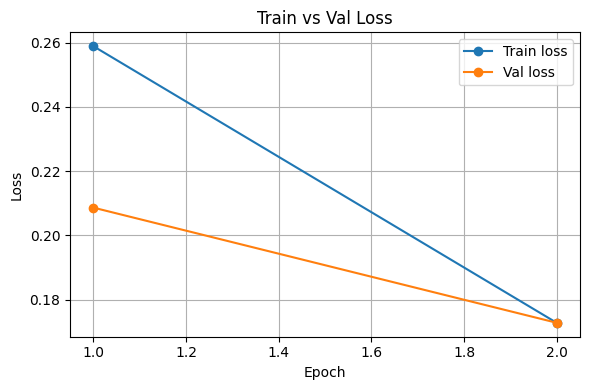

✓ Figure copiée vers repo : /content/qv-pipe-classifier/report/figures/baseline_framewise/loss_curves.png


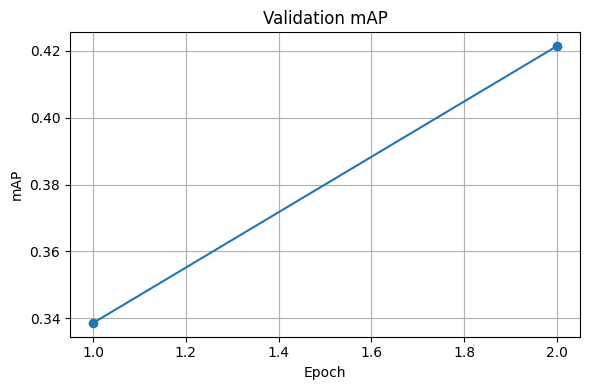

✓ Figure copiée vers repo : /content/qv-pipe-classifier/report/figures/baseline_framewise/val_map.png


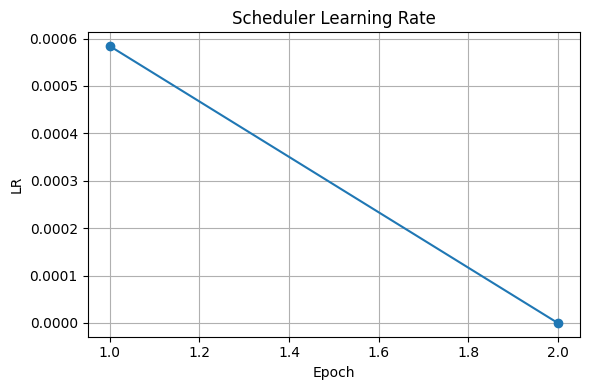

✓ Figure copiée vers repo : /content/qv-pipe-classifier/report/figures/baseline_framewise/lr_schedule.png

✓ Toutes les figures ont été sauvegardées dans Drive et dans le repo GitHub.
Dossier repo : /content/qv-pipe-classifier/report/figures/baseline_framewise


In [5]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import shutil

# ====== 1. Chemins ======
history_path = Path("/content/drive/MyDrive/QV Pipe/models/baseline_framewise/resnet18_fold0/history.json")
repo_fig_dir = Path("/content/qv-pipe-classifier/report/figures/baseline_framewise")
repo_fig_dir.mkdir(parents=True, exist_ok=True)

# ====== 2. Charger les données ======
with open(history_path, "r") as f:
    history = json.load(f)

train_loss = history["train_loss"]
val_loss   = history["val_loss"]
val_map    = history["val_map"]
lr         = history["lr"]

epochs = list(range(1, len(train_loss) + 1))

# Dossier Drive où sont stockées les figures
drive_output_dir = history_path.parent

# ====== 3. Fonction utilitaire pour double sauvegarde ======
def save_both(fig_path_drive, fig_path_repo):
    shutil.copy(fig_path_drive, fig_path_repo)
    print(f"✓ Figure copiée vers repo : {fig_path_repo}")

# ====== 4. Loss ======
plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, marker="o", label="Train loss")
plt.plot(epochs, val_loss, marker="o", label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend(); plt.grid(True)
loss_path_drive = drive_output_dir / "loss_curves.png"
plt.tight_layout(); plt.savefig(loss_path_drive, dpi=200)
plt.show()

save_both(loss_path_drive, repo_fig_dir / "loss_curves.png")

# ====== 5. mAP ======
plt.figure(figsize=(6,4))
plt.plot(epochs, val_map, marker="o")
plt.xlabel("Epoch"); plt.ylabel("mAP")
plt.title("Validation mAP")
plt.grid(True)
map_path_drive = drive_output_dir / "val_map.png"
plt.tight_layout(); plt.savefig(map_path_drive, dpi=200)
plt.show()

save_both(map_path_drive, repo_fig_dir / "val_map.png")

# ====== 6. Learning Rate ======
plt.figure(figsize=(6,4))
plt.plot(epochs, lr, marker="o")
plt.xlabel("Epoch"); plt.ylabel("LR")
plt.title("Scheduler Learning Rate")
plt.grid(True)
lr_path_drive = drive_output_dir / "lr_schedule.png"
plt.tight_layout(); plt.savefig(lr_path_drive, dpi=200)
plt.show()

save_both(lr_path_drive, repo_fig_dir / "lr_schedule.png")

print("\n✓ Toutes les figures ont été sauvegardées dans Drive et dans le repo GitHub.")
print(f"Dossier repo : {repo_fig_dir}")


# 4. Entrainements 20 epochs sur les 5 folds

## Entrainement Fold 0

In [10]:
# Paramètres
FOLD = 0                 # Change pour 1, 2, 3, 4 quand tu veux
EPOCHS = 20              # Entraînement complet
BATCH_SIZE = 16
LR = 1e-3
NUM_WORKERS = 12         # Accélération du DataLoader

%cd {PROJECT_ROOT}

CMD = f"""
python -m src.train.framewise_baseline \\
    --frames_dir "{DRIVE_ROOT}" \\
    --splits_csv "{SPLITS_DIR / 'frames_5_forstep1and2_folds.csv'}" \\
    --labels_json "{LABELS_PATH}" \\
    --models_dir "{MODELS_DIR}" \\
    --fold {FOLD} \\
    --epochs {EPOCHS} \\
    --batch_size {BATCH_SIZE} \\
    --lr {LR} \\
    --num_workers {NUM_WORKERS}
"""

print("Commande exécutée :")
print(CMD)

!{CMD}


/content/qv-pipe-classifier
Commande exécutée :

python -m src.train.framewise_baseline \
    --frames_dir "/content/drive/MyDrive/QV Pipe" \
    --splits_csv "/content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv" \
    --labels_json "/content/drive/MyDrive/QV Pipe/data/labels/track1-qv_pipe_train.json" \
    --models_dir "/content/drive/MyDrive/QV Pipe/models/baseline_framewise" \
    --fold 0 \
    --epochs 20 \
    --batch_size 16 \
    --lr 0.001 \
    --num_workers 12

Using device: cuda
Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv
Found 5968 videos with labels.
Inferred num_classes = 17
Fold 0: train videos = 4765, val videos = 1203
Train batches: 298, Val batches: 76
Creating backbone: resnet18
model.safetensors: 100% 46.8M/46.8M [00:00<00:00, 83.1MB/s]
/content/qv-pipe-classifier/src/train/framewise_baseline.py:500: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp

## Entrainement Fold 1

In [11]:
# Paramètres
FOLD = 1                 # Change pour 1, 2, 3, 4 quand tu veux
EPOCHS = 20              # Entraînement complet
BATCH_SIZE = 16
LR = 1e-3
NUM_WORKERS = 12         # Accélération du DataLoader

%cd {PROJECT_ROOT}

CMD = f"""
python -m src.train.framewise_baseline \\
    --frames_dir "{DRIVE_ROOT}" \\
    --splits_csv "{SPLITS_DIR / 'frames_5_forstep1and2_folds.csv'}" \\
    --labels_json "{LABELS_PATH}" \\
    --models_dir "{MODELS_DIR}" \\
    --fold {FOLD} \\
    --epochs {EPOCHS} \\
    --batch_size {BATCH_SIZE} \\
    --lr {LR} \\
    --num_workers {NUM_WORKERS}
"""

print("Commande exécutée :")
print(CMD)

!{CMD}

/content/qv-pipe-classifier
Commande exécutée :

python -m src.train.framewise_baseline \
    --frames_dir "/content/drive/MyDrive/QV Pipe" \
    --splits_csv "/content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv" \
    --labels_json "/content/drive/MyDrive/QV Pipe/data/labels/track1-qv_pipe_train.json" \
    --models_dir "/content/drive/MyDrive/QV Pipe/models/baseline_framewise" \
    --fold 1 \
    --epochs 20 \
    --batch_size 16 \
    --lr 0.001 \
    --num_workers 12

Using device: cuda
Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv
Found 5968 videos with labels.
Inferred num_classes = 17
Fold 1: train videos = 4760, val videos = 1208
Train batches: 298, Val batches: 76
Creating backbone: resnet18
/content/qv-pipe-classifier/src/train/framewise_baseline.py:500: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda

## Entrainement Fold 2

In [12]:
# Paramètres
FOLD = 2                 # Change pour 1, 2, 3, 4 quand tu veux
EPOCHS = 20              # Entraînement complet
BATCH_SIZE = 16
LR = 1e-3
NUM_WORKERS = 12         # Accélération du DataLoader

%cd {PROJECT_ROOT}

CMD = f"""
python -m src.train.framewise_baseline \\
    --frames_dir "{DRIVE_ROOT}" \\
    --splits_csv "{SPLITS_DIR / 'frames_5_forstep1and2_folds.csv'}" \\
    --labels_json "{LABELS_PATH}" \\
    --models_dir "{MODELS_DIR}" \\
    --fold {FOLD} \\
    --epochs {EPOCHS} \\
    --batch_size {BATCH_SIZE} \\
    --lr {LR} \\
    --num_workers {NUM_WORKERS}
"""

print("Commande exécutée :")
print(CMD)

!{CMD}

/content/qv-pipe-classifier
Commande exécutée :

python -m src.train.framewise_baseline \
    --frames_dir "/content/drive/MyDrive/QV Pipe" \
    --splits_csv "/content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv" \
    --labels_json "/content/drive/MyDrive/QV Pipe/data/labels/track1-qv_pipe_train.json" \
    --models_dir "/content/drive/MyDrive/QV Pipe/models/baseline_framewise" \
    --fold 2 \
    --epochs 20 \
    --batch_size 16 \
    --lr 0.001 \
    --num_workers 12

Using device: cuda
Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv
Found 5968 videos with labels.
Inferred num_classes = 17
Fold 2: train videos = 4822, val videos = 1146
Train batches: 302, Val batches: 72
Creating backbone: resnet18
/content/qv-pipe-classifier/src/train/framewise_baseline.py:500: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda

## Entrainement Fold 3

In [13]:
# Paramètres
FOLD = 3                 # Change pour 1, 2, 3, 4 quand tu veux
EPOCHS = 20              # Entraînement complet
BATCH_SIZE = 16
LR = 1e-3
NUM_WORKERS = 12         # Accélération du DataLoader

%cd {PROJECT_ROOT}

CMD = f"""
python -m src.train.framewise_baseline \\
    --frames_dir "{DRIVE_ROOT}" \\
    --splits_csv "{SPLITS_DIR / 'frames_5_forstep1and2_folds.csv'}" \\
    --labels_json "{LABELS_PATH}" \\
    --models_dir "{MODELS_DIR}" \\
    --fold {FOLD} \\
    --epochs {EPOCHS} \\
    --batch_size {BATCH_SIZE} \\
    --lr {LR} \\
    --num_workers {NUM_WORKERS}
"""

print("Commande exécutée :")
print(CMD)

!{CMD}

/content/qv-pipe-classifier
Commande exécutée :

python -m src.train.framewise_baseline \
    --frames_dir "/content/drive/MyDrive/QV Pipe" \
    --splits_csv "/content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv" \
    --labels_json "/content/drive/MyDrive/QV Pipe/data/labels/track1-qv_pipe_train.json" \
    --models_dir "/content/drive/MyDrive/QV Pipe/models/baseline_framewise" \
    --fold 3 \
    --epochs 20 \
    --batch_size 16 \
    --lr 0.001 \
    --num_workers 12

Using device: cuda
Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv
Found 5968 videos with labels.
Inferred num_classes = 17
Fold 3: train videos = 4757, val videos = 1211
Train batches: 298, Val batches: 76
Creating backbone: resnet18
/content/qv-pipe-classifier/src/train/framewise_baseline.py:500: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda

## Entrainement Fold 4

In [14]:
# Paramètres
FOLD = 4                 # Change pour 1, 2, 3, 4 quand tu veux
EPOCHS = 20              # Entraînement complet
BATCH_SIZE = 16
LR = 1e-3
NUM_WORKERS = 12         # Accélération du DataLoader

%cd {PROJECT_ROOT}

CMD = f"""
python -m src.train.framewise_baseline \\
    --frames_dir "{DRIVE_ROOT}" \\
    --splits_csv "{SPLITS_DIR / 'frames_5_forstep1and2_folds.csv'}" \\
    --labels_json "{LABELS_PATH}" \\
    --models_dir "{MODELS_DIR}" \\
    --fold {FOLD} \\
    --epochs {EPOCHS} \\
    --batch_size {BATCH_SIZE} \\
    --lr {LR} \\
    --num_workers {NUM_WORKERS}
"""

print("Commande exécutée :")
print(CMD)

!{CMD}

/content/qv-pipe-classifier
Commande exécutée :

python -m src.train.framewise_baseline \
    --frames_dir "/content/drive/MyDrive/QV Pipe" \
    --splits_csv "/content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv" \
    --labels_json "/content/drive/MyDrive/QV Pipe/data/labels/track1-qv_pipe_train.json" \
    --models_dir "/content/drive/MyDrive/QV Pipe/models/baseline_framewise" \
    --fold 4 \
    --epochs 20 \
    --batch_size 16 \
    --lr 0.001 \
    --num_workers 12

Using device: cuda
Loading splits CSV from /content/drive/MyDrive/QV Pipe/data/splits/frames_5_forstep1and2_folds.csv
Found 5968 videos with labels.
Inferred num_classes = 17
Fold 4: train videos = 4768, val videos = 1200
Train batches: 298, Val batches: 75
Creating backbone: resnet18
/content/qv-pipe-classifier/src/train/framewise_baseline.py:500: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda